# Self-Correction Evaluation

In this notebook, we analyze the results of all dataset–model pairs from the self-refinement evaluation experiment. The analysis focuses on model performance before and after hint injection, the role of the `max_tokens` parameter used during generation, and comparisons among model families.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plots import plot_by_dataset, plot_aggregated_metric_by_dataset, plot_model_category_comparison, plot_metric_heatmap, plot_accuracy_vs_correction_scatter

In [2]:
# Load data
metrics = pd.read_csv("metrics.csv")

In [3]:
MODELS_NON_REASONING=[
  "google/gemma-2-2b-it",
  "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "microsoft/Phi-4-mini-instruct",
  "Qwen/Qwen2.5-Math-1.5B",
  "Qwen/Qwen2.5-Math-7B" # not sure keep or not
]

MODELS_REASONING=[
  "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
  "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B",
  "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
  "microsoft/Phi-4-mini-reasoning"
]

In [4]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Model categorization
def categorize_model(model_name):
    reasoning_keywords = [
        "DeepSeek-R1",
        "Phi-4-mini-reasoning"
    ]
    for keyword in reasoning_keywords:
        if keyword in model_name:
            return "Reasoning"
    return "Non-Reasoning"

# Simplify model names for plots
def simplify_model_name(model_name):
    if "/" in model_name:
        return model_name.split("/")[-1]
    return model_name

# Apply to metrics
metrics["model_category"] = metrics["model"].apply(categorize_model)
metrics["model_short"] = metrics["model"].apply(simplify_model_name)


## I. Effect of Maximum Token Budget
This section analyzes how increasing the maximum number of tokens affects model performance across different datasets.

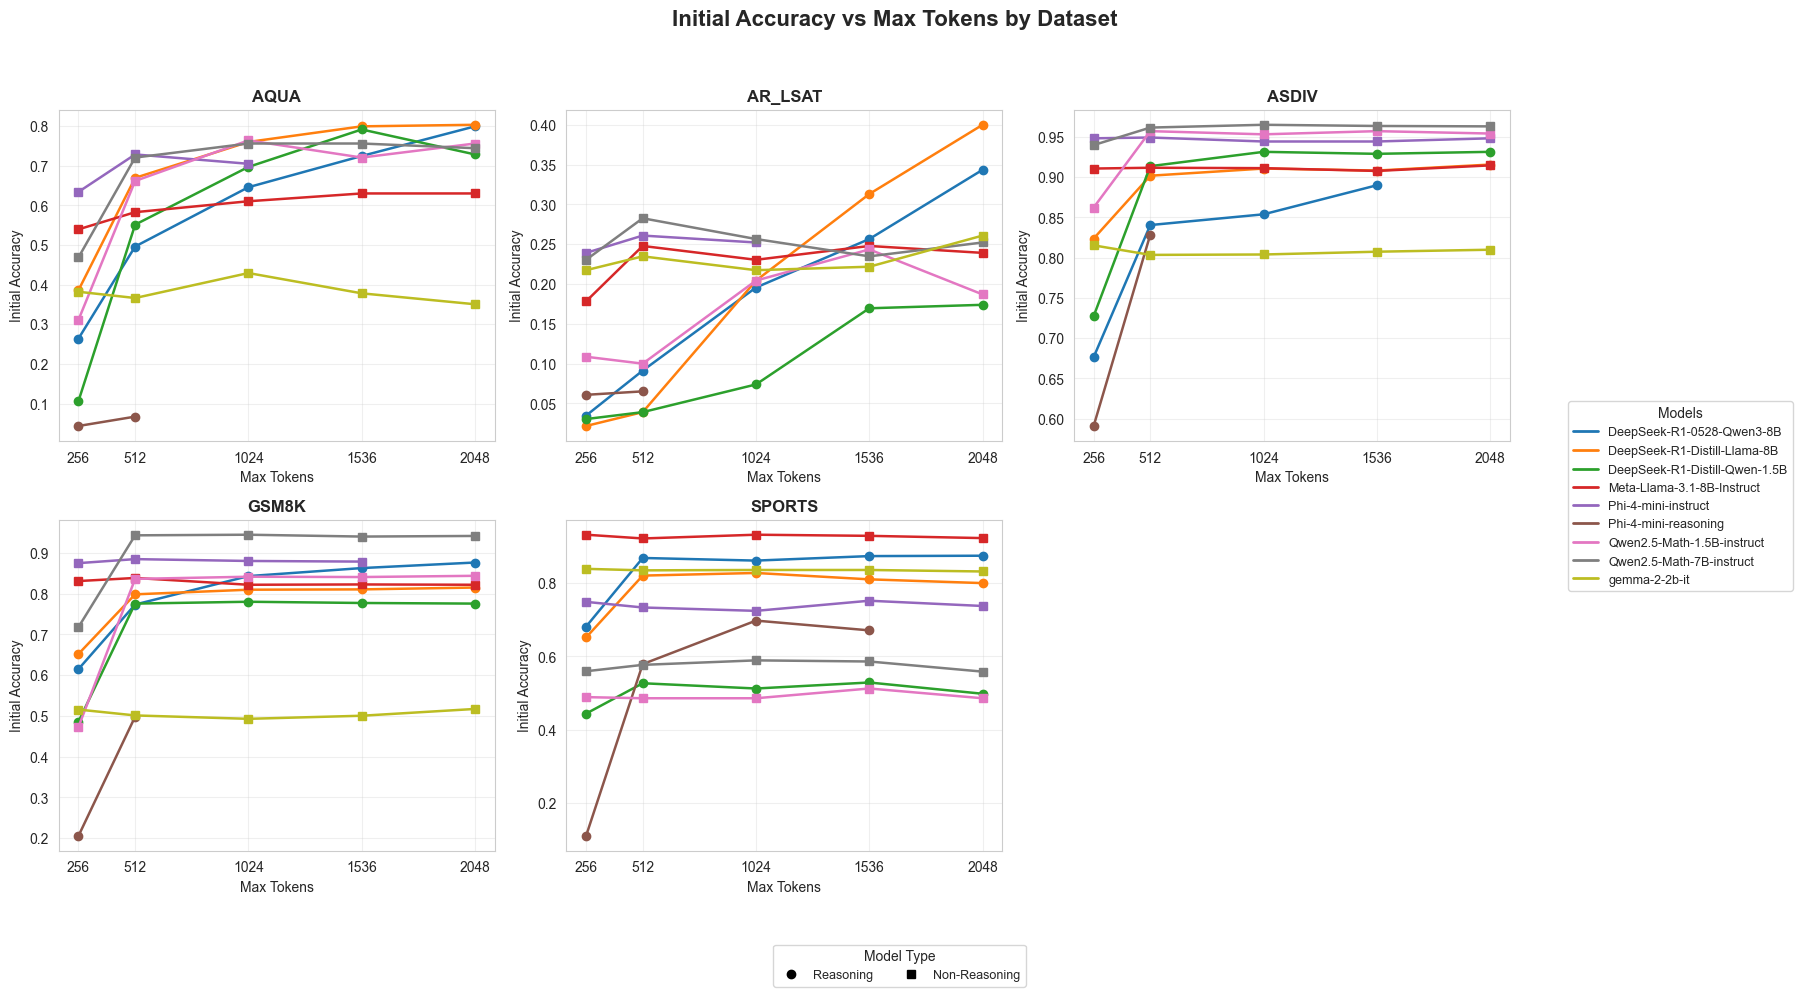

In [5]:
# Initial Accuracy
plot_by_dataset(
    metrics, "initial_accuracy", "Initial Accuracy",
    "Initial Accuracy vs Max Tokens by Dataset"
)

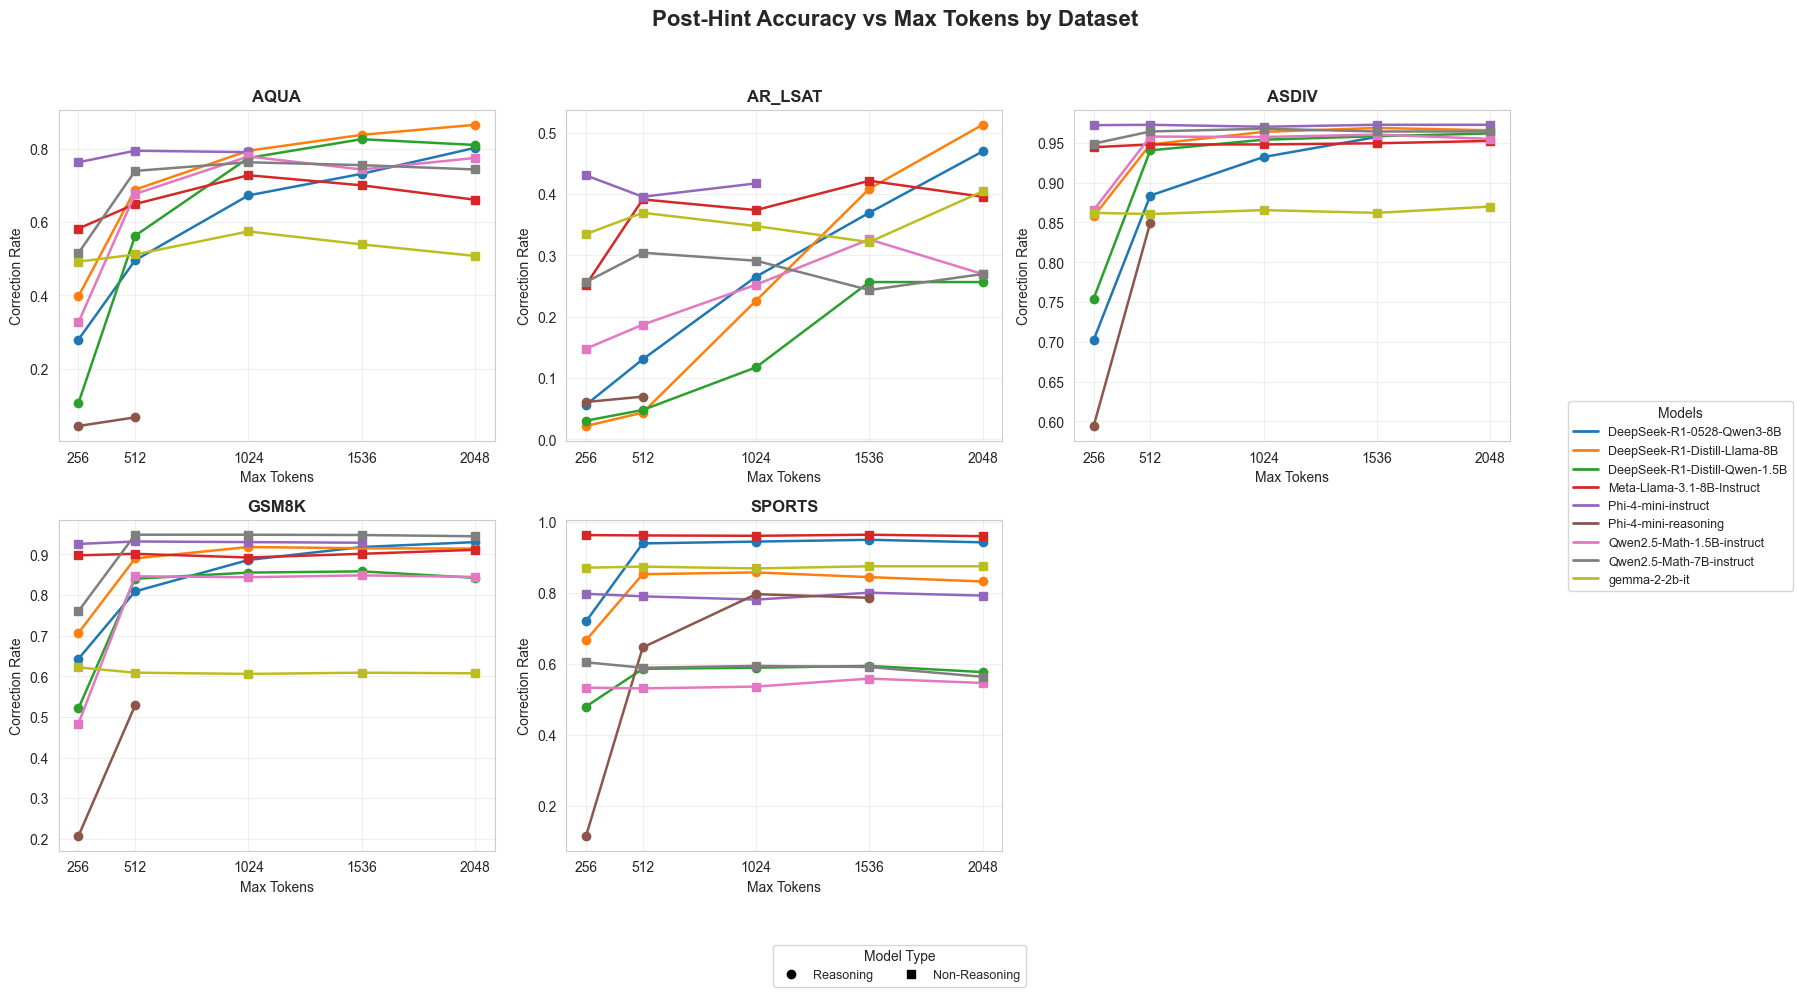

In [6]:
# Per-dataset y-scale
plot_by_dataset(
    metrics, "post_hint_accuracy", "Correction Rate",
    "Post-Hint Accuracy vs Max Tokens by Dataset"
)

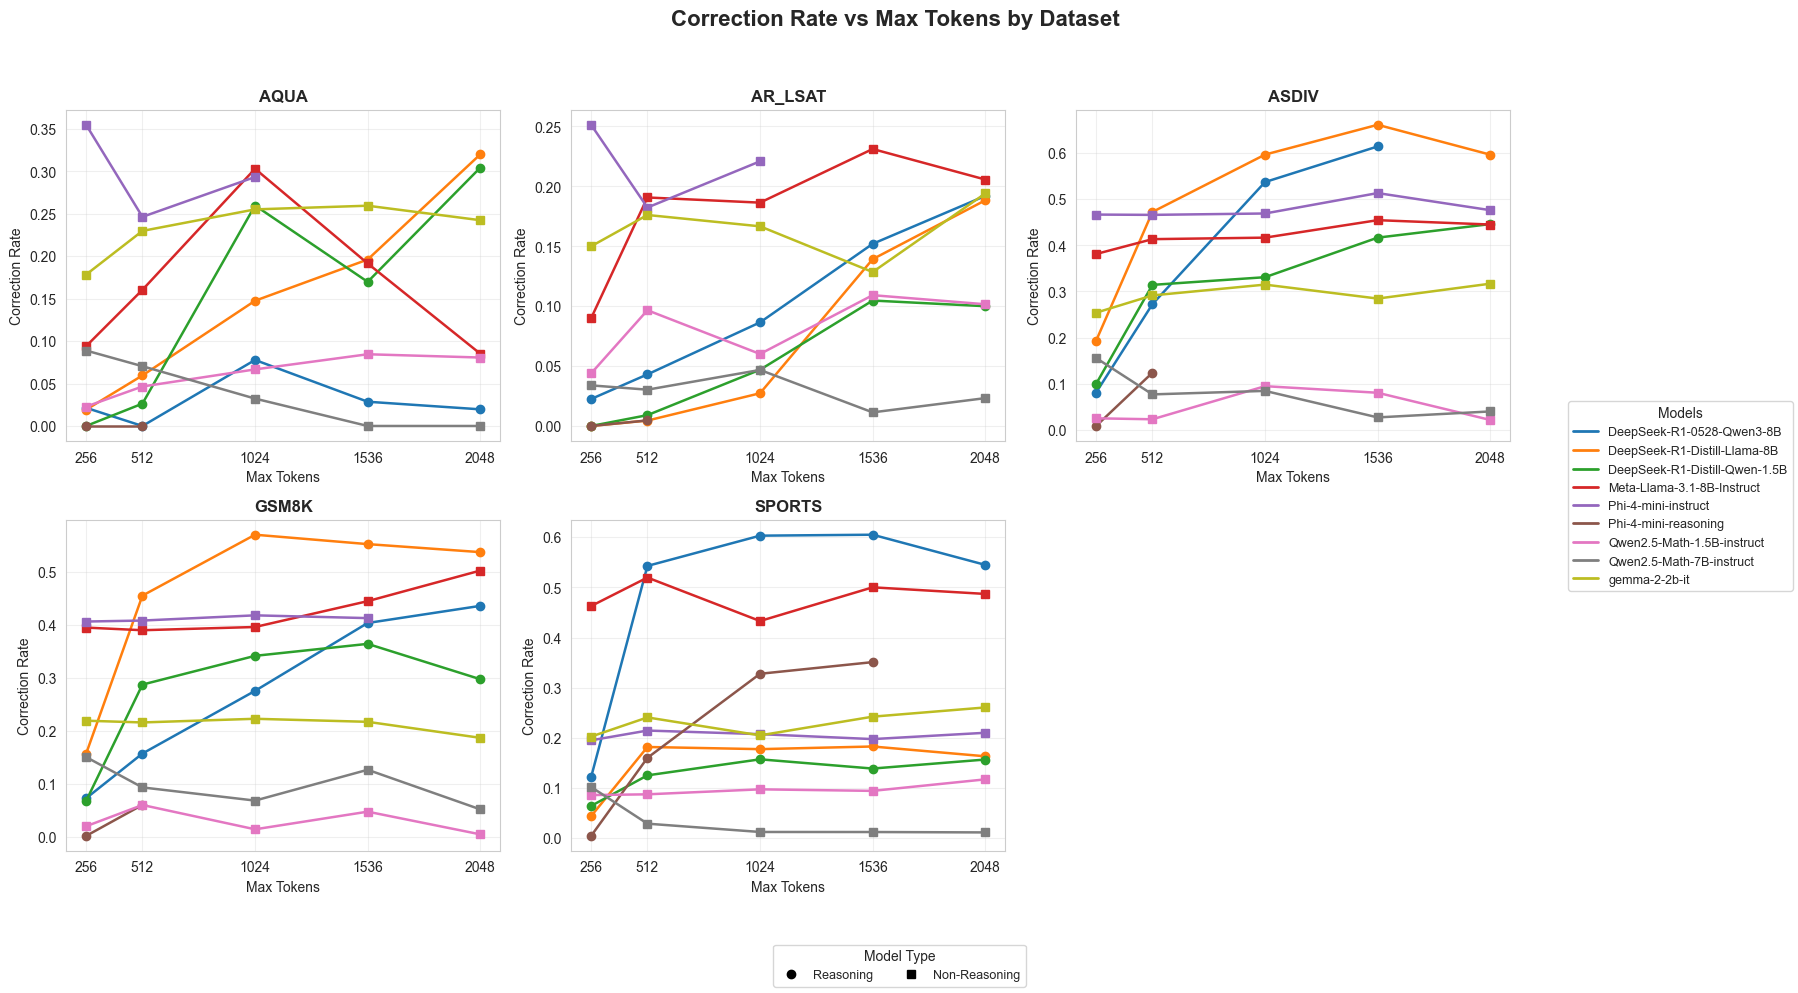

In [7]:
# Per-dataset y-scale
plot_by_dataset(
    metrics, "correction_rate", "Correction Rate",
    "Correction Rate vs Max Tokens by Dataset"
)

## II. Analysis of Aggregated Performance Metrics

In [8]:
aggregated_metrics = (
    metrics
    .groupby(['model_short', 'dataset', 'model_category'])
    .agg({
        'initial_accuracy': 'mean',
        'post_hint_accuracy': 'mean',
        'delta_accuracy': 'mean',
        'n_incorrect_initial': 'sum',
        'n_corrected': 'sum',
        'correction_rate': 'mean'
    })
    .reset_index()
)

aggregated_metrics.head(5)

,model_short,dataset,model_category,initial_accuracy,post_hint_accuracy,delta_accuracy,n_incorrect_initial,n_corrected,correction_rate
0,DeepSeek-R1-0528-Qwen3-8B,aqua,Reasoning,0.585827,0.596850,0.011024,526,14,0.029469
1,DeepSeek-R1-0528-Qwen3-8B,ar_lsat,Reasoning,0.184348,0.258261,0.073913,938,85,0.099234
2,DeepSeek-R1-0528-Qwen3-8B,asdiv,Reasoning,0.815002,0.869006,0.054004,1497,437,0.376218
3,DeepSeek-R1-0528-Qwen3-8B,gsm8k,Reasoning,0.794086,0.837301,0.043215,1358,285,0.268857
4,DeepSeek-R1-0528-Qwen3-8B,sports,Reasoning,0.831493,0.899387,0.067894,824,332,0.483385


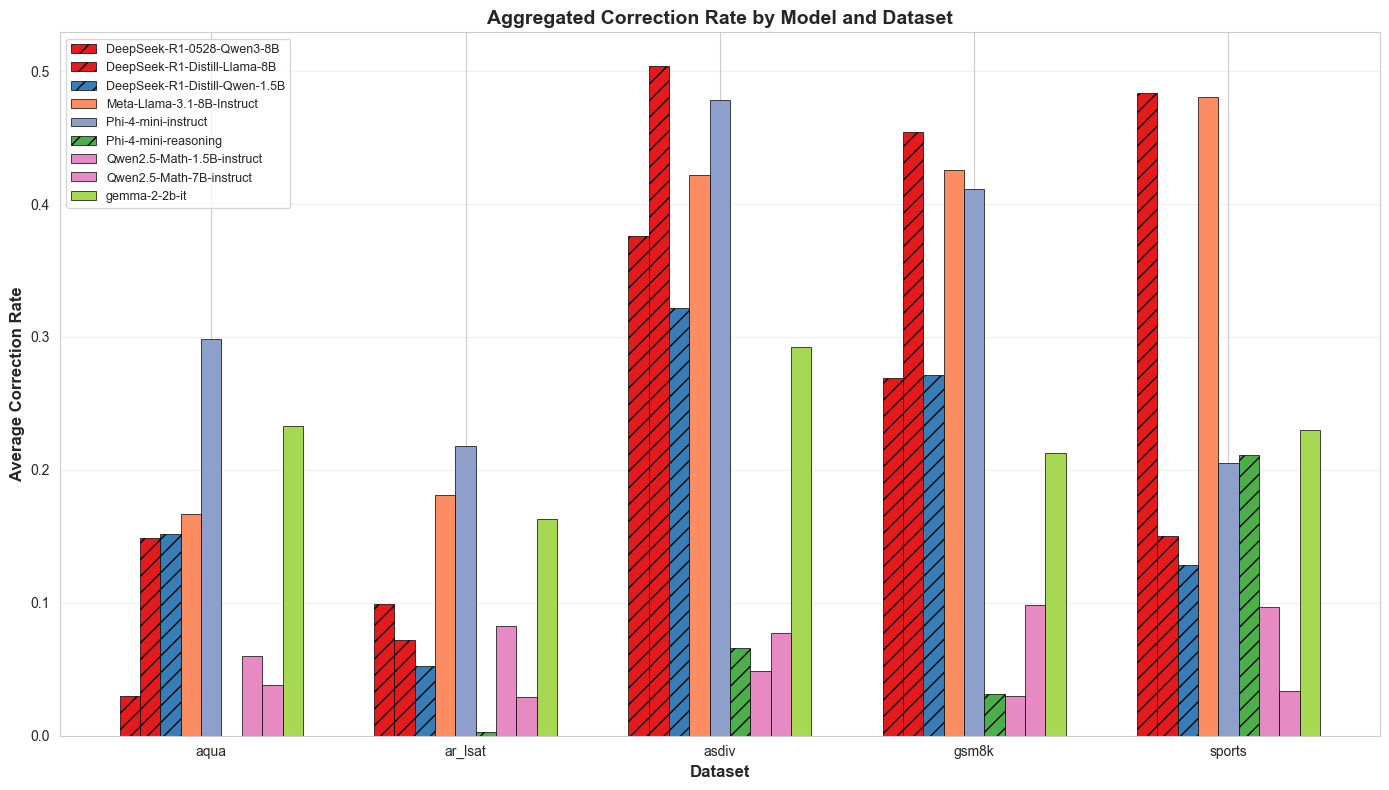

In [9]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='correction_rate',
    ylabel='Average Correction Rate',
    title='Aggregated Correction Rate by Model and Dataset'
)


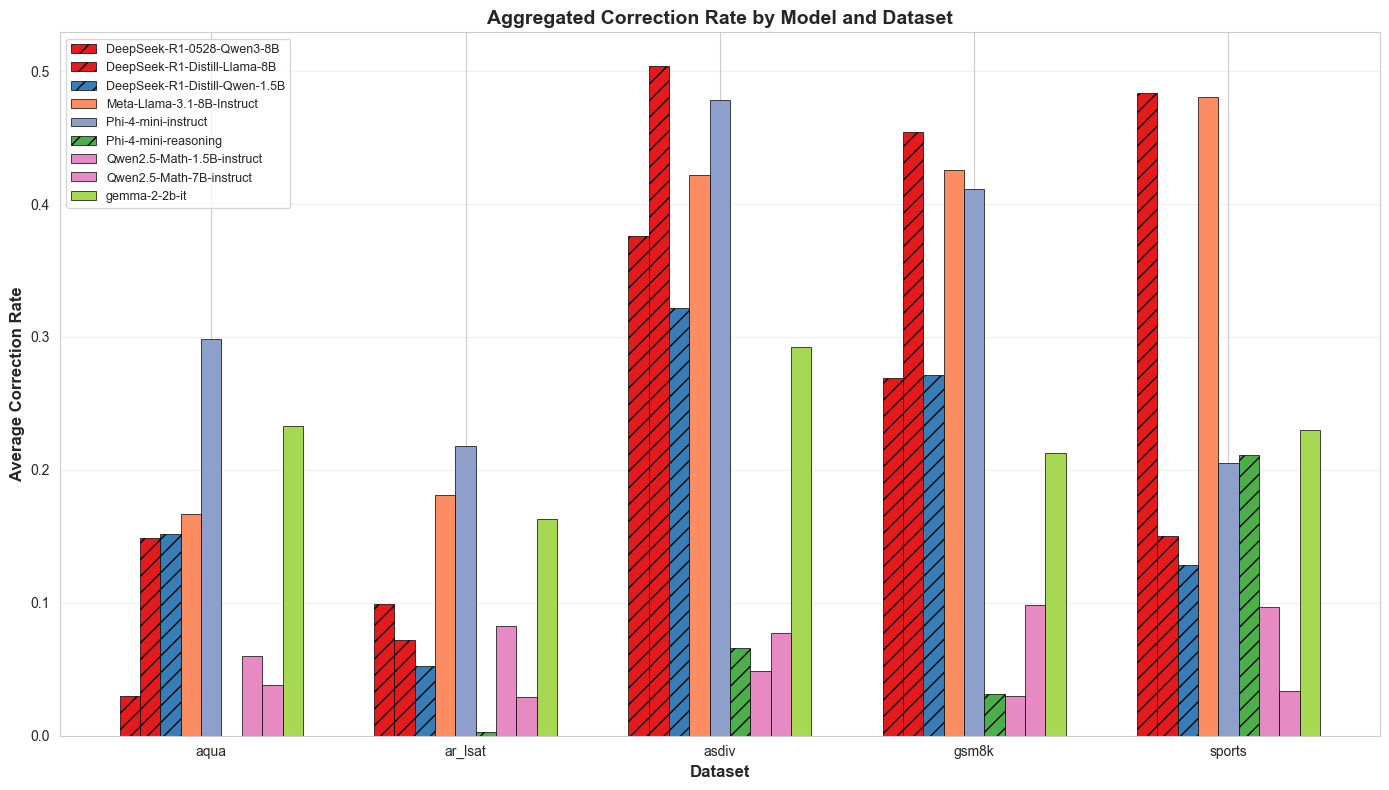

In [10]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='correction_rate',
    ylabel='Average Correction Rate',
    title=('Aggregated Correction Rate by Model and Dataset')
)


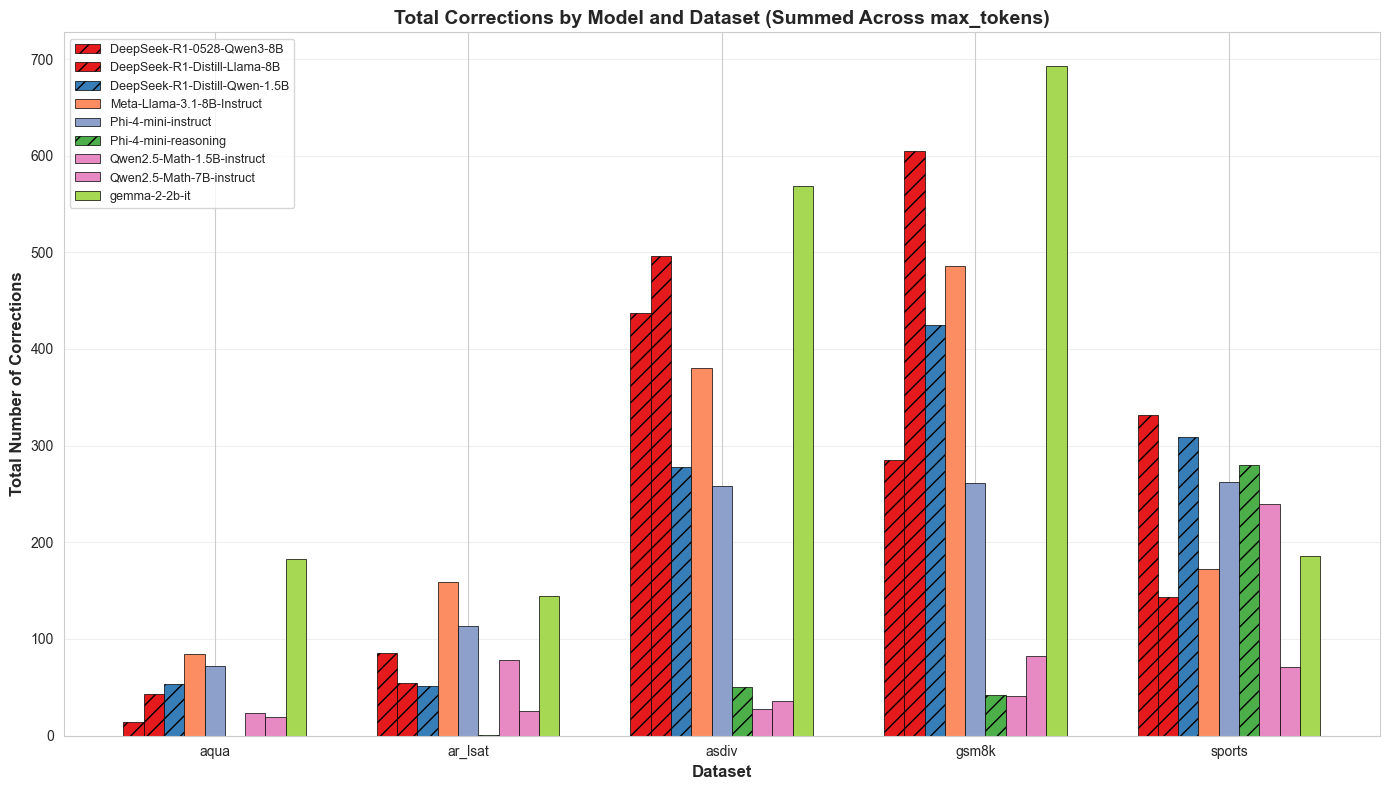

In [11]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='n_corrected',
    ylabel='Total Number of Corrections',
    title='Total Corrections by Model and Dataset (Summed Across max_tokens)'
)


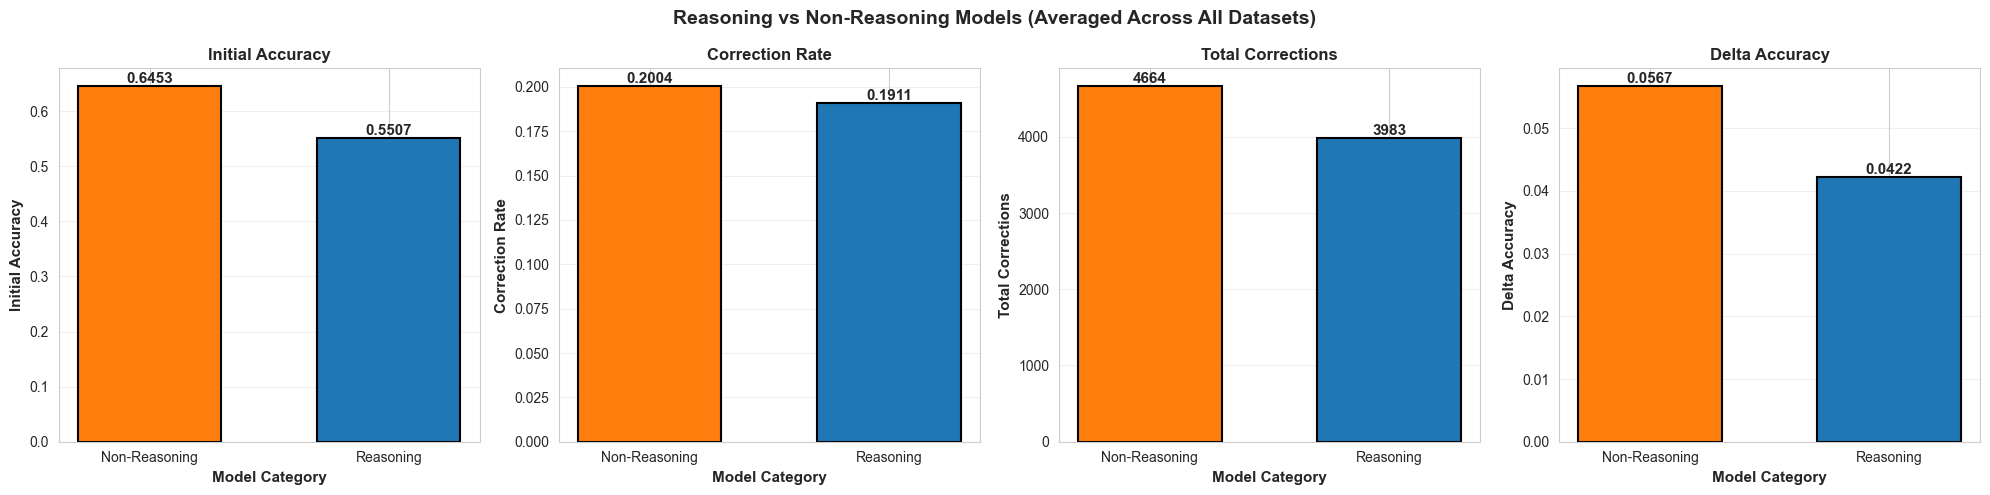

In [12]:
plot_model_category_comparison(aggregated_metrics)

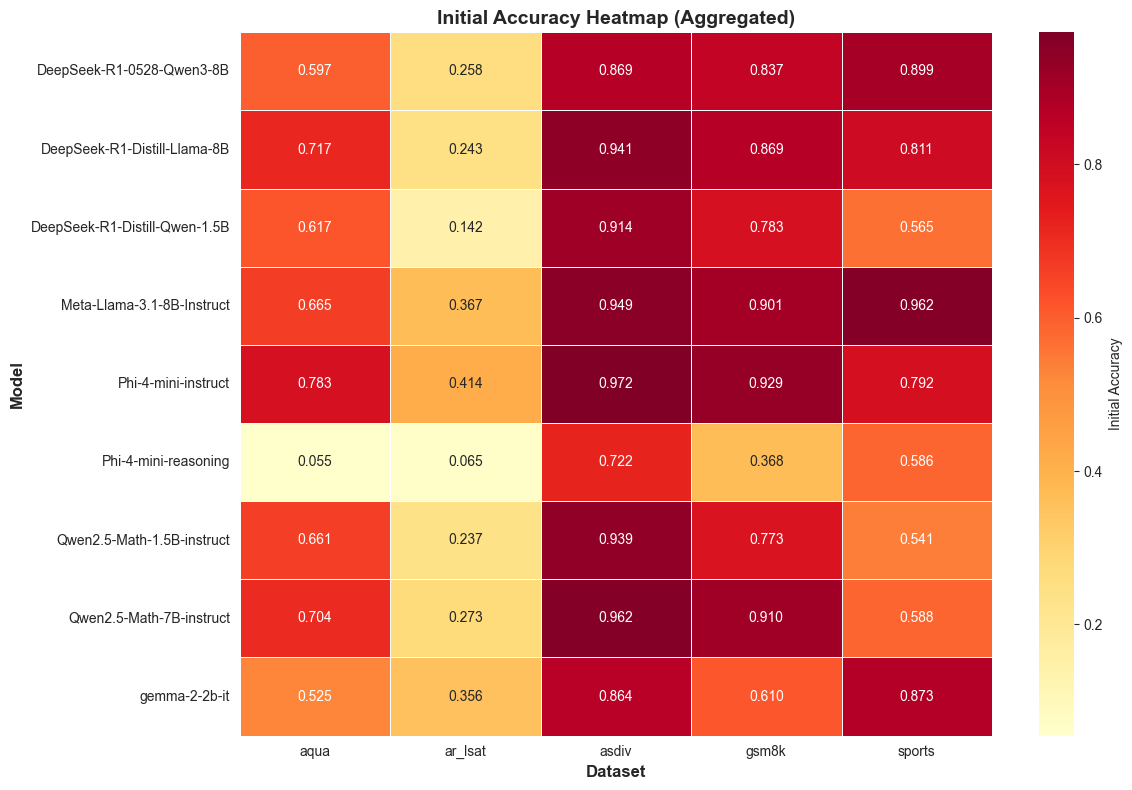

dataset,aqua,ar_lsat,asdiv,gsm8k,sports
model_short,,,,,
DeepSeek-R1-0528-Qwen3-8B,0.596850,0.258261,0.869006,0.837301,0.899387
DeepSeek-R1-Distill-Llama-8B,0.717323,0.242609,0.940880,0.868840,0.810838
DeepSeek-R1-Distill-Qwen-1.5B,0.616535,0.141739,0.913890,0.783321,0.565031
Meta-Llama-3.1-8B-Instruct,0.664567,0.366957,0.948591,0.900834,0.962168
Phi-4-mini-instruct,0.783465,0.414493,0.972219,0.929113,0.792434
Phi-4-mini-reasoning,0.055118,0.065217,0.721948,0.367703,0.585890
Qwen2.5-Math-1.5B-instruct,0.660630,0.236522,0.939298,0.773313,0.540695
Qwen2.5-Math-7B-instruct,0.703937,0.273043,0.962037,0.909932,0.588344
gemma-2-2b-it,0.525197,0.355652,0.864063,0.610462,0.873006


In [13]:
# 9. Initial Accuracy (your code used post_hint_accuracy; keep that exact behavior)
plot_metric_heatmap(
    aggregated_metrics,
    value_col="post_hint_accuracy",
    title="Initial Accuracy Heatmap (Aggregated)",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Initial Accuracy"
)


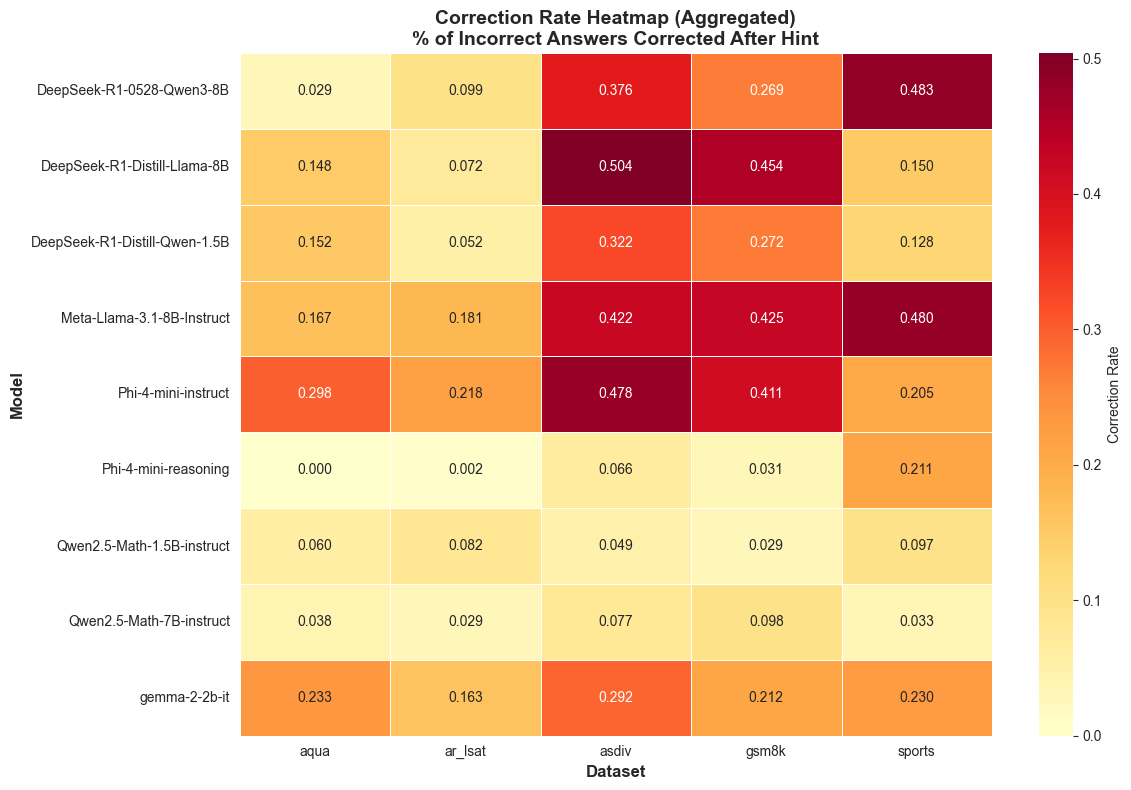

dataset,aqua,ar_lsat,asdiv,gsm8k,sports
model_short,,,,,
DeepSeek-R1-0528-Qwen3-8B,0.029469,0.099234,0.376218,0.268857,0.483385
DeepSeek-R1-Distill-Llama-8B,0.148475,0.071899,0.504021,0.454071,0.149876
DeepSeek-R1-Distill-Qwen-1.5B,0.152043,0.052142,0.321514,0.271526,0.128498
Meta-Llama-3.1-8B-Instruct,0.166804,0.180813,0.422184,0.425321,0.480369
Phi-4-mini-instruct,0.298183,0.218237,0.478235,0.411044,0.204947
Phi-4-mini-reasoning,0.000000,0.002326,0.066187,0.031166,0.210857
Qwen2.5-Math-1.5B-instruct,0.060238,0.082286,0.048956,0.029431,0.096505
Qwen2.5-Math-7B-instruct,0.038314,0.029121,0.076839,0.098179,0.033486
gemma-2-2b-it,0.233050,0.163082,0.292366,0.212285,0.230217


In [14]:
# 10. Correction Rate
plot_metric_heatmap(
    aggregated_metrics,
    value_col="correction_rate",
    title="Correction Rate Heatmap (Aggregated)\n% of Incorrect Answers Corrected After Hint",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Correction Rate"
)

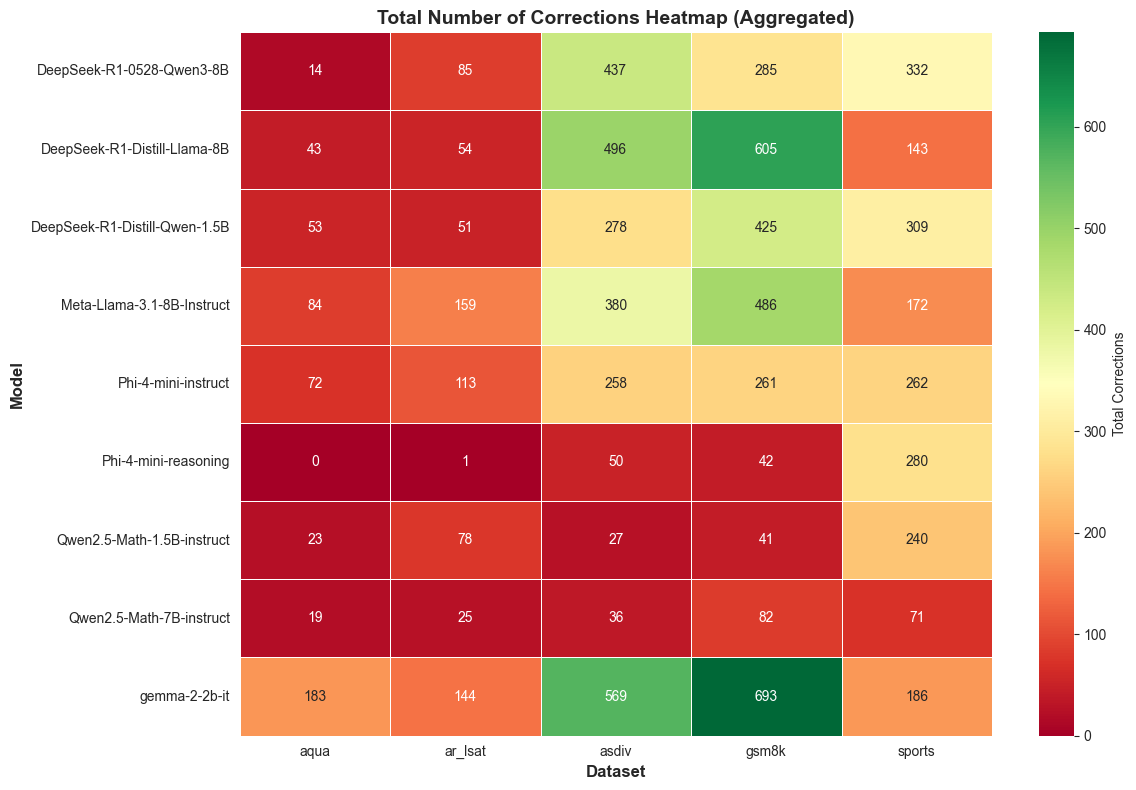

dataset,aqua,ar_lsat,asdiv,gsm8k,sports
model_short,,,,,
DeepSeek-R1-0528-Qwen3-8B,14,85,437,285,332
DeepSeek-R1-Distill-Llama-8B,43,54,496,605,143
DeepSeek-R1-Distill-Qwen-1.5B,53,51,278,425,309
Meta-Llama-3.1-8B-Instruct,84,159,380,486,172
Phi-4-mini-instruct,72,113,258,261,262
Phi-4-mini-reasoning,0,1,50,42,280
Qwen2.5-Math-1.5B-instruct,23,78,27,41,240
Qwen2.5-Math-7B-instruct,19,25,36,82,71
gemma-2-2b-it,183,144,569,693,186


In [15]:
# 11. Total Corrections
plot_metric_heatmap(
    aggregated_metrics,
    value_col="n_corrected",
    title="Total Number of Corrections Heatmap (Aggregated)",
    cmap="RdYlGn",
    fmt=".0f",
    cbar_label="Total Corrections"
)

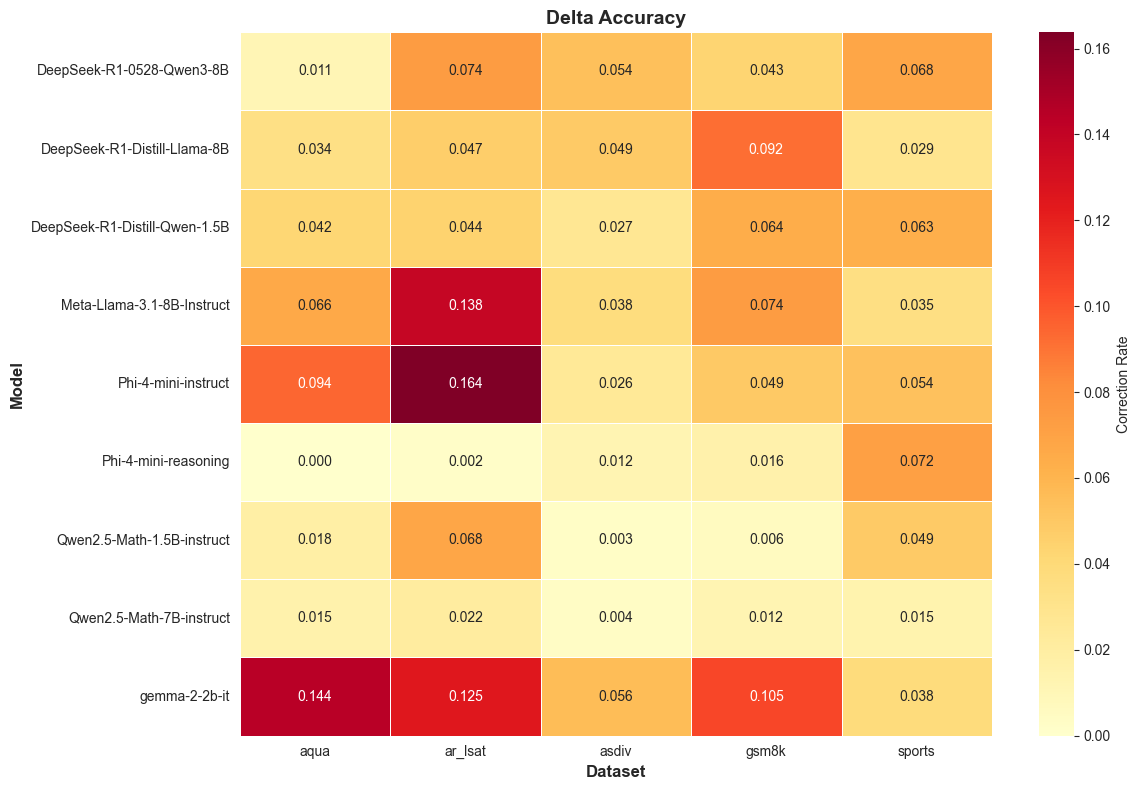

dataset,aqua,ar_lsat,asdiv,gsm8k,sports
model_short,,,,,
DeepSeek-R1-0528-Qwen3-8B,0.011024,0.073913,0.054004,0.043215,0.067894
DeepSeek-R1-Distill-Llama-8B,0.033858,0.046957,0.049036,0.091736,0.029243
DeepSeek-R1-Distill-Qwen-1.5B,0.041732,0.044348,0.027484,0.064443,0.063190
Meta-Llama-3.1-8B-Instruct,0.066142,0.138261,0.037568,0.073692,0.035174
Phi-4-mini-instruct,0.094488,0.163768,0.025507,0.049469,0.053579
Phi-4-mini-reasoning,0.000000,0.002174,0.012358,0.015921,0.071575
Qwen2.5-Math-1.5B-instruct,0.018110,0.067826,0.002669,0.006217,0.049080
Qwen2.5-Math-7B-instruct,0.014961,0.021739,0.003559,0.012434,0.014519
gemma-2-2b-it,0.144094,0.125217,0.056253,0.105080,0.038037


In [20]:
plot_metric_heatmap(
    aggregated_metrics,
    value_col="delta_accuracy",
    title="Delta Accuracy",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Correction Rate"
)

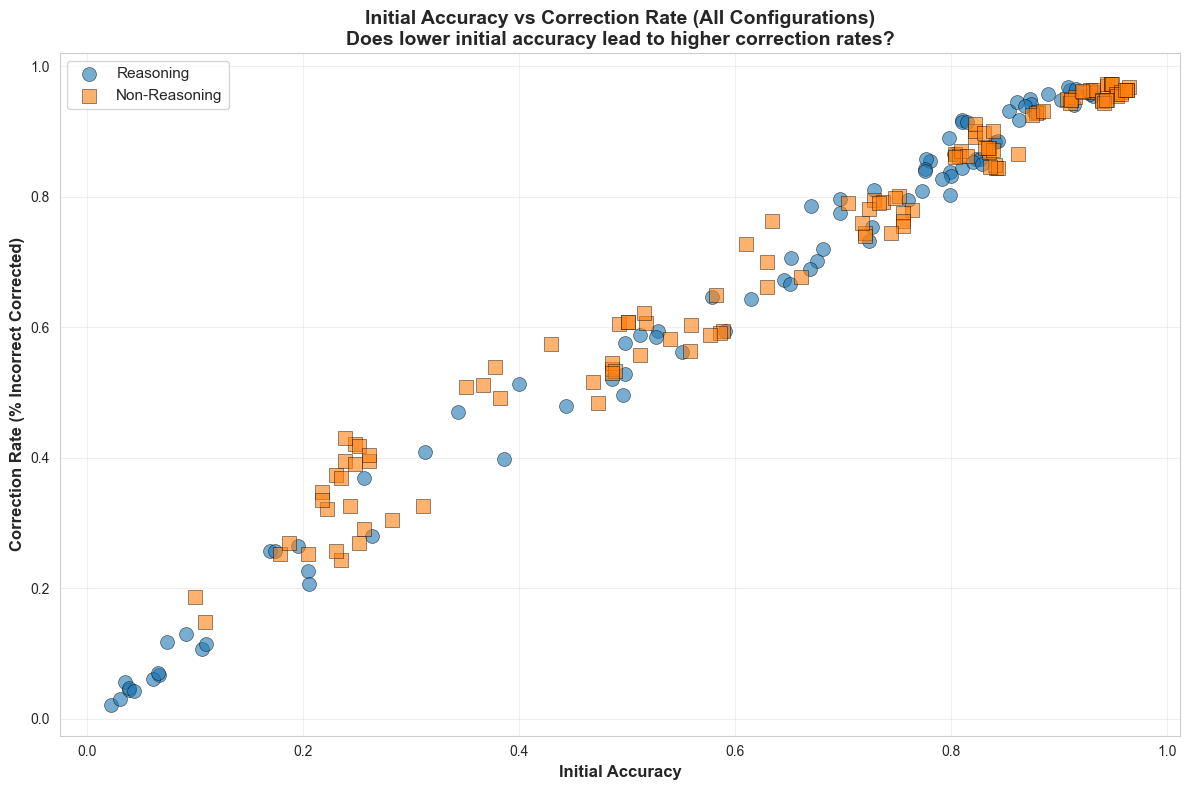

In [18]:
plot_accuracy_vs_correction_scatter(
    metrics,
    x_col="initial_accuracy",
    y_col="post_hint_accuracy",
    title="Initial Accuracy vs Correction Rate (All Configurations)\nDoes lower initial accuracy lead to higher correction rates?"
)


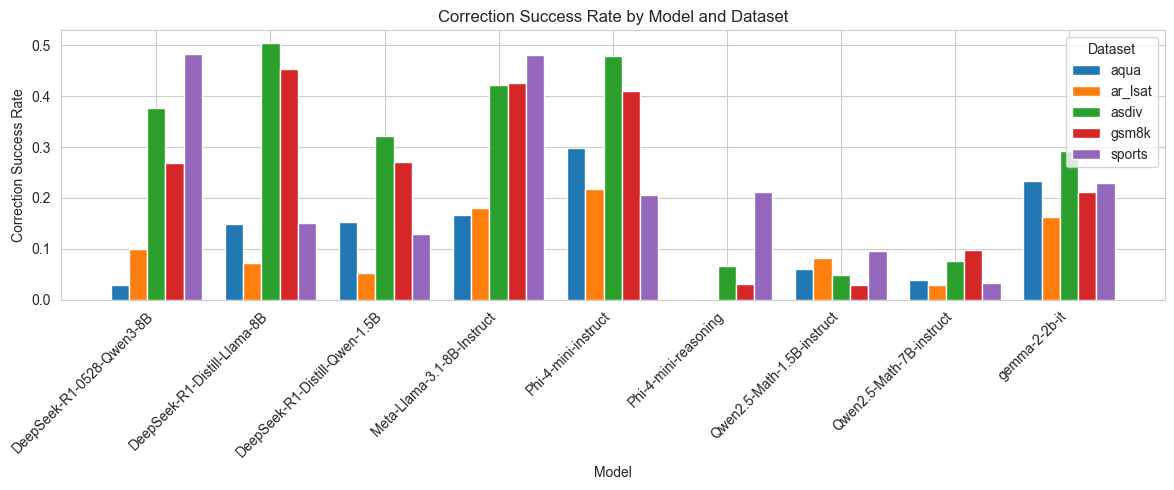

In [28]:
# Aggregate
grouped = (
    metrics
    .groupby(["model_short", "dataset"])["correction_rate"]
    .mean()
    .unstack()
)

models = grouped.index
datasets = grouped.columns

x = np.arange(len(models))
width = 0.8 / len(datasets)

plt.figure(figsize=(12, 5))

for i, dataset in enumerate(datasets):
    plt.bar(
        x + i * width,
        grouped[dataset],
        width,
        label=dataset
    )

plt.ylabel("Correction Success Rate")
plt.xlabel("Model")
plt.title("Correction Success Rate by Model and Dataset")
plt.xticks(x + width * (len(datasets) - 1) / 2, models, rotation=45, ha="right")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


### IV. Generated Tokens Number 

In [21]:
import matplotlib.pyplot as plt

def plot_grouped_boxplot(
    df,
    value_col,
    group_col,
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(12, 5),
    showfliers=True,
    rotation=45
):
    """
    Universal boxplot for distributions grouped by a categorical column.
    """

    groups = df[group_col].unique()

    data = [
        df[df[group_col] == g][value_col].values
        for g in groups
    ]

    plt.figure(figsize=figsize)

    plt.boxplot(
        data,
        labels=groups,
        showfliers=showfliers
    )

    plt.ylabel(ylabel or value_col, fontsize=12, fontweight="bold")
    plt.xlabel(xlabel or group_col, fontsize=12, fontweight="bold")

    plt.title(
        title or f"Distribution of {value_col} grouped by {group_col}",
        fontsize=14,
        fontweight="bold"
    )

    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_7254/4217235870.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


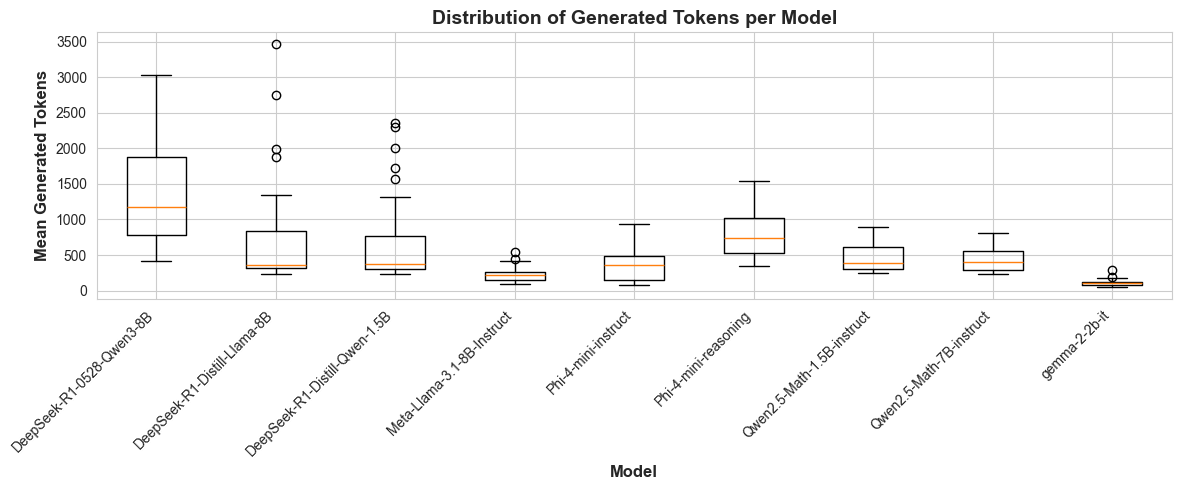

In [22]:
plot_grouped_boxplot(
    metrics,
    value_col="hint_tokens_mean",
    group_col="model_short",
    title="Distribution of Generated Tokens per Model",
    xlabel="Model",
    ylabel="Mean Generated Tokens"
)


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_7254/4217235870.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


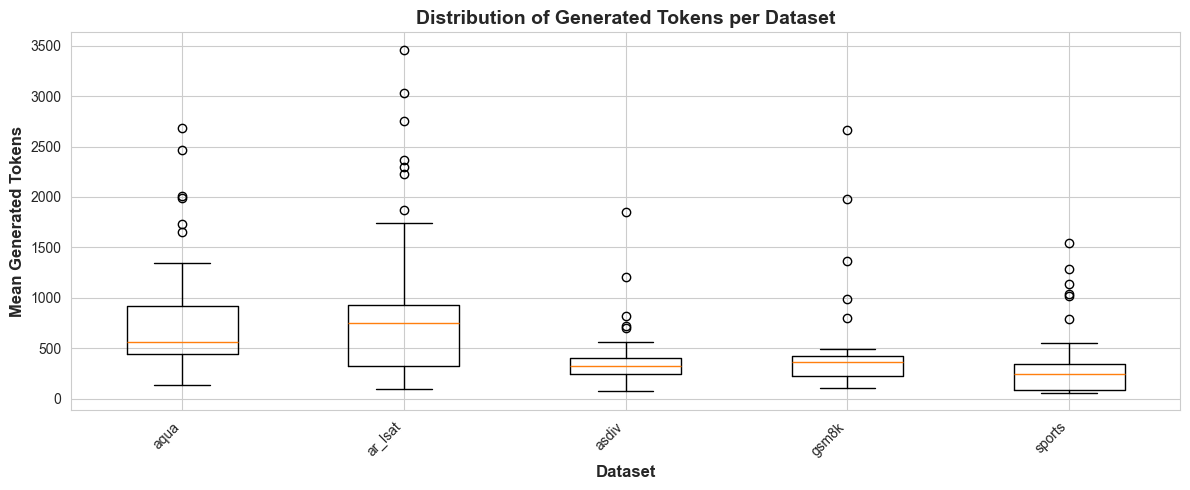

In [23]:
plot_grouped_boxplot(
    metrics,
    value_col="hint_tokens_mean",
    group_col="dataset",
    title="Distribution of Generated Tokens per Dataset",
    xlabel="Dataset",
    ylabel="Mean Generated Tokens"
)


In [34]:
metrics.columns

Index(['model', 'dataset', 'max_tokens', 'n_questions', 'initial_accuracy',
       'post_hint_accuracy', 'n_incorrect_initial', 'n_corrected',
       'correction_rate', 'delta_accuracy', 'initial_tokens_mean',
       'hint_tokens_mean', 'post_hint_tokens_mean', 'model_category',
       'model_short'],
      dtype='object')

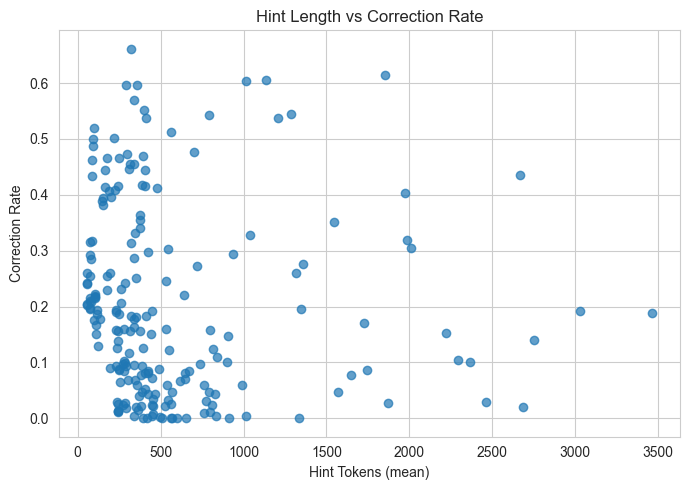

In [24]:
x = metrics["hint_tokens_mean"].values
y = metrics["correction_rate"].values

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Hint Tokens (mean)")
plt.ylabel("Correction Rate")
plt.title("Hint Length vs Correction Rate")
plt.tight_layout()
plt.show()


/var/folders/ct/y9tjcdz561zddxqtsrlssqxc0000gn/T/ipykernel_7254/3713091950.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bins.groupby("bin")


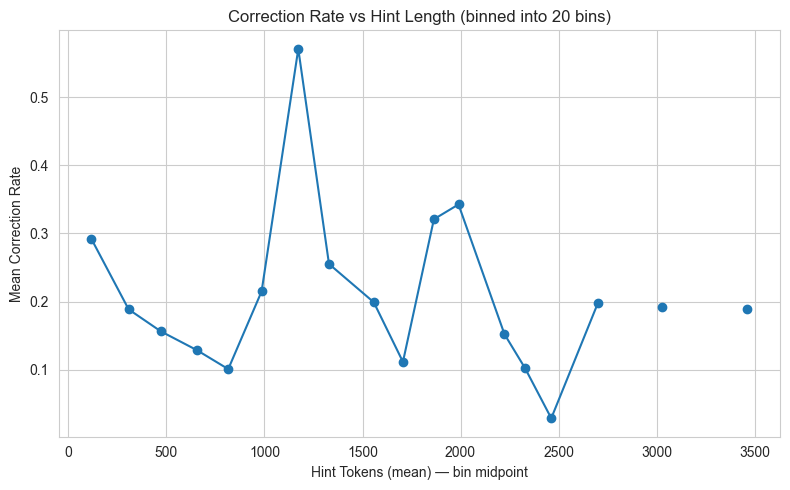

In [25]:
n_bins = 20  # you can change to 6–15 depending on how many points you have

df_bins = metrics[["hint_tokens_mean", "correction_rate"]].dropna().copy()
df_bins["bin"] = pd.cut(df_bins["hint_tokens_mean"], bins=n_bins)

binned = (
    df_bins.groupby("bin")
    .agg(
        hint_tokens_mid=("hint_tokens_mean", "mean"),
        correction_rate_mean=("correction_rate", "mean"),
        n=("correction_rate", "size"),
    )
    .reset_index(drop=True)
)

plt.figure(figsize=(8, 5))
plt.plot(binned["hint_tokens_mid"], binned["correction_rate_mean"], marker="o")
plt.xlabel("Hint Tokens (mean) — bin midpoint")
plt.ylabel("Mean Correction Rate")
plt.title(f"Correction Rate vs Hint Length (binned into {n_bins} bins)")
plt.tight_layout()
plt.show()
